Author: Damir Valput

Date: 29 January 2021

Program: Machine Learning Engineer nanodegree, Udacity

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The general task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase is given. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Machine Learning Workflow

These are the steps that I am going to perform to implement this application:

1. Data loading and exploration
2. Data cleaning, pre-processing and exploratoru visualisation
3. Feature engineering
4. Customer segmentation
5. Data scaling and train/test dataset definition

In [1]:
!pip install pandas-profiling

     |████████████████████████████████| 239 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 58.8 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 54.7 MB/s eta 0:00:01
     |████████████████████████████████| 594 kB 62.9 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 68.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 59.3 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 470 kB/s  eta 0:00:01
     |████████████████████████████████| 295 kB 63.0 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27084 sha256=29942e9917960ff9725784686a7085fac7783c51aa03476a7a985a60ed6ddb32
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/fe/0b/4450b38bceb9ae43dd7d0f16e353566f30f5f4d59a58eca2ed
  Created wheel for phik: filename=phik-0.11.0-py3-none-any.whl size=599735 sha256=10c8fd622f39abdb40383f353cff

In [2]:
import pandas as pd
import numpy as np
import math
import json

import os

import mxnet as mx

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
# sagemaker libraries
import sagemaker
import boto3

# 1. Data loading and exploratory data analysis

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Portfolio

In [6]:
portfolio.shape

(10, 6)

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [9]:
list(portfolio['offer_type'].unique())

['bogo', 'informational', 'discount']

Several things to notice from above:
* There are 10 different offers in `portfolio`;
* The values of the 'reward' columns span from 0 to 10, and it is an integer, with the mean reward of 4.20;
* Difficulty (minimum required spend to complete an offer) ranges from 0 to 20 (also an int), with a mean difficulty being 7.70;
* Duration of an offer, i.e. number of days that an offer will be active, is up to 10 days, with an average duration of 6.50 days;
* There are three different offer types: bogo, information, and discount;
* Informational offers have both difficulty and reward of 0;
* There are no incomplete rows in the `portfolio` table.

#### Profile

In [10]:
profile.shape

(17000, 5)

In [11]:
profile.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


From the preliminary analysis of the demographic data from the table `profile`, we can observe:
* The table `profile` contains 17,000 rows, i.e. 17,000 different customer profiles;
* There are some incomplete data rows;
* Mean age of a Starbucks customer is 62.53, with maximum of 118 years. Possibility of erroneous data (e.g. customer giving fake age when subscribing)?;
* Column `became_member_on` is in format `YYYYMMDD`, as integer;
* Mean income of starbucks customers is 65,404.99 (I presume $).

#### Transcript

In [13]:
transcript.shape

(306534, 4)

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


From the preliminary analysis of the demographic data from the table `transcript`, we can observe:

* There are 306,534 recorced transcripts, each described with 4 features: person (customer id as in `profile`), event (the type of transaction that is recorded), value (a dict), and time (test begins at t=0).

## Exploratory Data Analysis (EDA)

More detailed EDA will be performed using pandas-profiling package: https://github.com/pandas-profiling/pandas-profiling

In [16]:
pandas_profile_portfolio = ProfileReport(portfolio, title="Pandas Profiling Report for table 'portfolio' ")

In [17]:
pandas_profile_portfolio

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
#pandas_profile_portfolio.to_file("pandas_profile_table_portfolio.html")

In [19]:
channels_list = list(np.unique([y for x in portfolio['channels'] for y in x]))
channels_list

['email', 'mobile', 'social', 'web']

Remarks:
* There are no duplicate rows or missing values.
* 6 fields in dataframe: 3 numerical (reward, difficulty, duration), 2 categorical (offer_type, id), and 'channels' which is a list of strings (type not recognised by pandas-profiling).
* Difficulty and reward have similar histograms. 
* There are 4 possible channels via which an offer can be sent: ['email', 'mobile', 'social', 'web']
* There is a positive correlation between all numerical variables; however, while duration and reward are weakly correlated, reward and difficulty are fairly correlated, and duration and difficulty are quite strongly correlated.

In [20]:
pandas_profile_profile = ProfileReport(profile, title="Pandas Profiling Report for table 'profile' ")

In [21]:
#pandas_profile_profile.to_file("pandas_profile_table_profile.html")

In [22]:
pandas_profile_profile

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# how many rows have missing valus
n_missing_profiles = profile.shape[0] - profile.dropna().shape[0]
print("There are ", n_missing_profiles, " rows with at least one missing value.")

There are  2175  rows with at least one missing value.


In [24]:
profiles_over_100 = profile[profile['age'] > 100]
print("There are ", profiles_over_100.shape[0], " profiles with age over 100.")
print("Among the profiles with age over 100, there are ", 
      profiles_over_100.shape[0] - profiles_over_100.dropna().shape[0], " profiles with missing values.")

profiles_over_100.dropna()

There are  2180  profiles with age over 100.
Among the profiles with age over 100, there are  2175  profiles with missing values.


,gender,age,id,became_member_on,income
1556,F,101,4d2ccfcbbebf4bd9baf4b7e433d0e288,20171004,43000.0
4100,F,101,d2fdc2be8ab64e4ba04830d441e53fd5,20150526,99000.0
14846,F,101,e0ea90ddd2f147e082d21e97f51ec1b1,20171109,56000.0
15800,F,101,047ad0135cfe4c0ea5ba019da4de9c52,20170309,59000.0
16864,F,101,1593d617fac246ef8e50dbb0ffd77f5f,20171127,82000.0


Observations:
* There are 5 variables: 3 numerical (age, became_member_on, income), and 2 categorical (gender, id)
* 'Id' column has unique values, as it should be
* There no duplicate rows and 4350 missing values (around 5% of all cells in the table). The missing values occur in columns 'gender' and 'income', both with 2175 missing values. Further inspections showed that they all occur in same 2175 rows, that is, 'gender' and 'income' are always missing simultaneously.
* 'Gender' has three categories: M (8484 values), F (6129 values), and O (212 values).
* There are 85 distinct ages, with a surprisingly large number of customer with age over 100 (2180 profiles to be precise). In fact, inspecting further the dataframe `profiles` discovered that all the rows with missing values are in fact aged over 100, and as such the best would be to discard them from further analysis as outliers/anomalies. That leaves us 5 female profiles aged over 100 (concretely, age 101) with varying incomes.
* Age and income, as expcted, have a weaker positive correlation, while became_member_on is weakly negatively correlated with income and age. This means that there is a slight tendency that customers that joined more recently the Starbucks programme will tend to be slightly younger and naturally of lower income, which is again as one would expect.

In [25]:
pandas_profile_transcript = ProfileReport(transcript, title="Pandas Profiling Report for table 'transcript' ")

In [26]:
#pandas_profile_transcript.to_file("pandas_profile_table_transcript.html")

In [27]:
pandas_profile_transcript

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
keys_transactions = np.unique([y for x in list(transcript[transcript.event == 'transaction']['value']) for y in x.keys()])
list(keys_transactions)

['amount']

In [29]:
keys_non_transactions = np.unique([y for x in list(transcript[transcript.event != 'transaction']['value']) for y in x.keys()])
list(keys_non_transactions)

['offer id', 'offer_id', 'reward']

In [30]:
list(transcript[transcript.event == 'offer completed']['value'][:5])

[{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2},
 {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
 {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5},
 {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10},
 {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}]

Observations:
* There are no missing values in the table `transcript`.
* There are 2962 duplicate rows, which is not very surprising since one client can perform some transactions multiple times.
* The variable 'event' is categorical, with for possible categories: ** [transaction, offer received, offer viewed, offer completed]**.
* Most common event type is *transaction*, recorded 138,953 times (around 45% of all the events), followed by offer received (76,277 records or 25%), offer viewed (around 19%), and lastly offer completed (around 11%).
* In the 'person' variable, there are 17,000 different categories - which corresponds to the number of different customer profiles registered, meaning that every customer has at least one event recorded. In fact, 5.5% of the customer profiles appear only once in this table (935 profiles), i.e. they have only one event assigned to them. A customer profile with most occurrences in the table has 51 events assigned to them.
* If the event type is 'transaction', then the only key in the dictionary of the variable 'value' is amount (of that transaction). Otherwise, the possible keys are:
    * **offer id / offer_id - the format used depends on whether the event is offer_received or not**
    * **reward** - the reward a customer received in case of completing an offer
* Time, which is the number of hours since the test started, has 120 distinct values, spaning from 0 to 714 hours (29.75 days).


## Data cleaning

The tables I am working with are pretty clean already. During the exploratory analysis, the following was identified as necessary to perform to make datasets suitable for further analysis and feature creation:
* drop any incomplete rows of data in the table `profile`

In [34]:
print('(orig profile) rows, cols: ', profile.shape)

# drop any incomplete data, set client id as index column
clean_profile = profile.dropna(axis=0).set_index("id")
print('(clean profile) rows, cols: ', clean_profile.shape)

(orig profile) rows, cols:  (17000, 5)
(clean profile) rows, cols:  (14825, 4)


In [35]:
# became_member_on to datetime format
clean_profile["became_member_on"] = pd.to_datetime(clean_profile["became_member_on"], format='%Y%m%d')

In [36]:
clean_profile.head()

,gender,age,became_member_on,income
id,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0
e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0
389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0
2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0


In [37]:
print("The newest memeber in the database became a member on ", max(clean_profile.became_member_on))
print("The latest transaction in the database has been performed", max(transcript.time), \
      "days since the beginning of test.")

The newest memeber in the database became a member on  2018-07-26 00:00:00
The latest transaction in the database has been performed 714 days since the beginning of test.


In [38]:
def calculate_profile_metrics(df_profile):
    """
    It calculates a series of metrics from the cleaned profile dataframe.
    
    Returns a new dataframe with the original and newly calculated columns.
    """
    # calculate number of days someone has been a member starting from the reference day

    ref_date = max(df_profile.became_member_on) + pd.DateOffset(1) #set reference day as the latest day + 1
    print("The date set as a reference is ", ref_date)

    # calculate membership duration w.r.t. ref_date
    df_profile['membership_duration'] = (ref_date - df_profile['became_member_on']).dt.days

    # metric of income relative to their age --> MOVE THIS TO FEATURE ENGINEERING!
    df_profile["income_age"] = np.divide(df_profile['income'].values, df_profile['age'].values)


    """
    categorise by common age groups, as follows:
    18-24: group 1 (young adults, commonly uni),
    25-34: group 2 (young professionals),
    35-54: group 3 (middle age),
    55-64: group 4 (older adults),
    65+: group 5 (retirement).
    """

    age_bins = [17, 24, 34, 54, 64, 118]
    df_profile['age_group'] = pd.cut(df_profile['age'].values, age_bins, right=True, labels = False) + 1

    return df_profile

In [39]:
def split_transcripts(df_transcript):
    """
    This function splits the transcripts dataframe into transactions and offers, and
    returns the two corresponding dataframes.
    """
    
    # extract just transcripts that were transactions
    df_transactions = df_transcript[df_transcript['event'] == 'transaction']
    
    # extract the amount of each transactions from the dict in 'value'
    df_transactions['amount'] = df_transactions['value'].apply(lambda x: x['amount'])
    
    # offer transcripts
    df_offers = df_transcript[df_transcript['event'] != 'transaction']
    
    return df_transactions, df_offers

In [40]:
def calculate_profile_transaction_metrics(df_profile, df_transactions, df_transcripts):
    """
    It calculates a series of metrics using the cleaned profile dataframe, and the dataframe on
    customer transactions.
    
    Returns a new dataframe with the original and newly calculated columns.
    """
    
    # count number of all transcripts (offer e) of each customer
    df_profile['num_trancripts'] = df_transcripts['person'].value_counts()
    #df_profile['num_trancripts_norm'] = df_transcripts['person'].value_counts(normalize=True) # normalised

    # count just the transactions a member did since the beginning of the test
    df_profile['num_transactions'] = df_transactions['person'].value_counts()

    # sum all the transactions a customer made during the test
    df_profile['total_transactions'] = df_transactions.groupby('person')['amount'].sum()
    
    # replace nan with 0 if the counting methods didn't find any values
    values = {'num_transactions': 0, 'total_transactions':0}
    df_profile.fillna(value=values, inplace=True)

    # add average per transaction
    df_profile['avg_per_transaction'] = df_profile['total_transactions'].values / (df_profile['num_transactions'].values + 1)

    # buying frequency: average days between transactions
    df_profile['buying_frequency'] = df_profile['membership_duration'].values / (df_profile['num_transactions'].values + 1)
    
    return df_profile


In [41]:
df_transactions, df_offers = split_transcripts(transcript)
profile_temp = calculate_profile_metrics(clean_profile)
profile_final = calculate_profile_transaction_metrics(profile_temp, df_transactions, transcript)

The date set as a reference is  2018-07-27 00:00:00


In [42]:
profile_final.head()

,gender,age,became_member_on,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency
id,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,377,2036.363636,4,6,3.0,77.01,19.25250,94.25
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,444,1333.333333,5,18,7.0,159.27,19.90875,55.50
e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0,92,1029.411765,5,12,3.0,57.73,14.43250,23.00
389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0,168,815.384615,5,20,3.0,36.43,9.10750,42.00
2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0,258,879.310345,4,10,4.0,15.62,3.12400,51.60


## Visualizing the data: customer profiles

Below I am visualising histograms for several variables of customer profiles. 

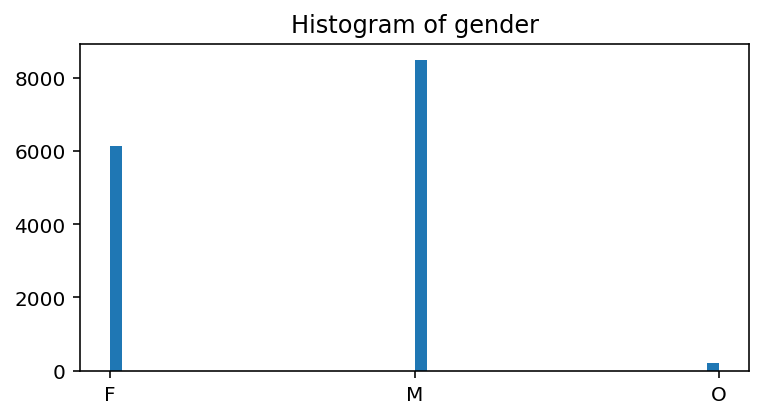

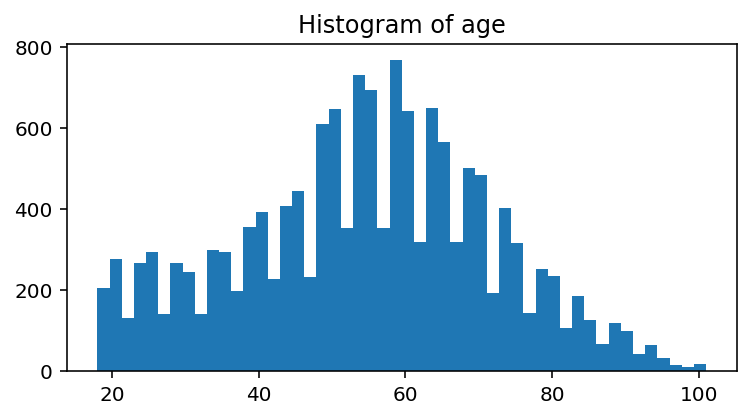

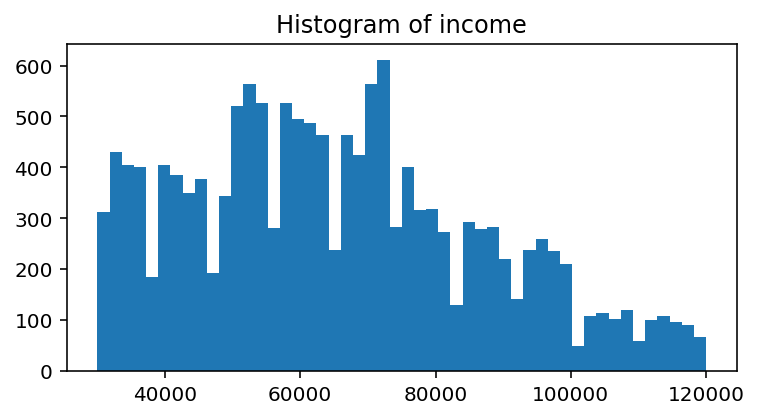

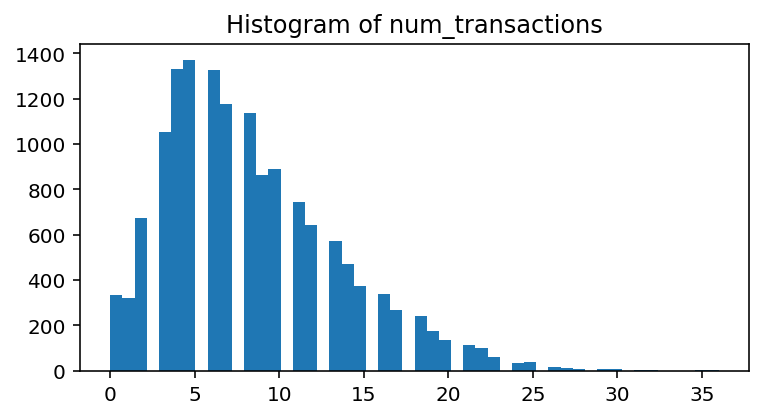

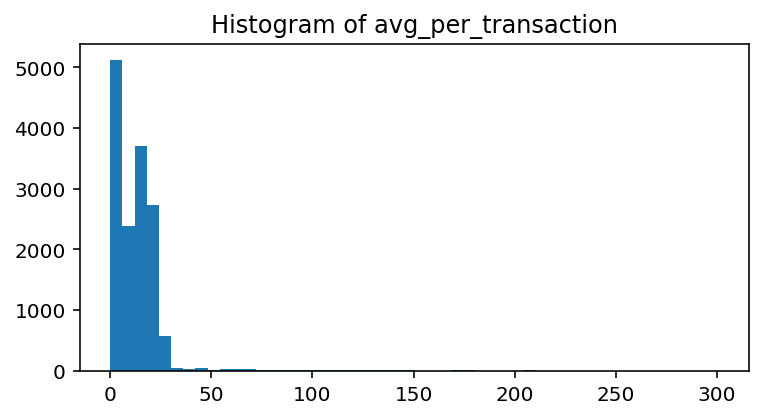

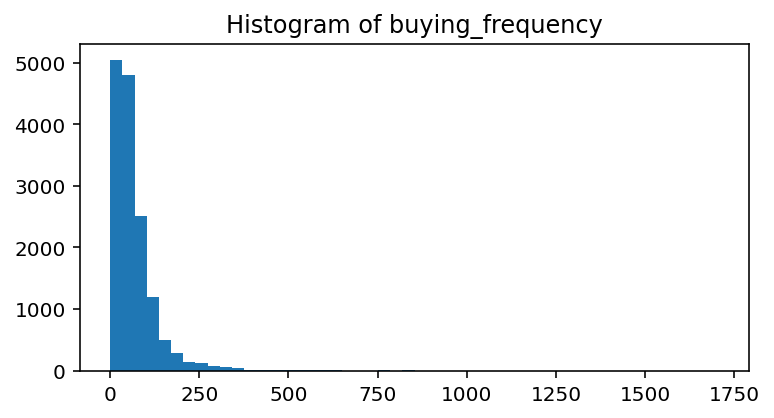

In [43]:
profile_features_list = ['gender', 'age', 'income', 'num_transactions', 'avg_per_transaction', 'buying_frequency']
n_bins = 50

for column_name in profile_features_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(profile_final[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

In [43]:
# map gender to 0/1: 0 - female, 1 - male, 2 - O
gender_mapping_int = {"gender": {'F':0, 'M':1, 'O':2}}
profile_final = profile_final.replace(gender_mapping_int)

In [44]:
# drop the features that are not going to be used in clustering
profile_final.drop('became_member_on', axis=1, inplace=True)

In [45]:
profile_final.head()

,gender,age,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency
id,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0,55,112000.0,377,2036.363636,4,6,3.0,77.01,19.25250,94.25
78afa995795e4d85b5d9ceeca43f5fef,0,75,100000.0,444,1333.333333,5,18,7.0,159.27,19.90875,55.50
e2127556f4f64592b11af22de27a7932,1,68,70000.0,92,1029.411765,5,12,3.0,57.73,14.43250,23.00
389bc3fa690240e798340f5a15918d5c,1,65,53000.0,168,815.384615,5,20,3.0,36.43,9.10750,42.00
2eeac8d8feae4a8cad5a6af0499a211d,1,58,51000.0,258,879.310345,4,10,4.0,15.62,3.12400,51.60


## Cleaning the table 'transcript'

Table transcript has been separated into two tables by event type: offer events vs. transactions.

In [46]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [47]:
def process_offer_dataframes(df, offer_event, portfolio):
    """
    Receives a dataframe with either received, viewed or completed offers.
    
    It extracts values from the column 'value' into separate columns.
    Values that extracts are offer id and reward (in case of a completed offer).
    
    offer_event can be: {received, viewed, completed}
    
    """
    if offer_event == 'completed':
        df['offer_id'] = df['value'].apply(lambda x: x['offer_id'])
        df['reward'] = df['value'].apply(lambda x: x['reward'])
    else:
        df['offer_id'] = df['value'].apply(lambda x: x['offer id'])
        
    # drop the value column as it was processed
    df.drop('value', axis=1, inplace=True)
    
    # add offer_type and duration
    df = df.merge(portfolio[['id','offer_type', 'duration']], how='left', left_on='offer_id', right_on='id')
    df.drop('id', axis=1, inplace=True)
    
    # add duration in hrs
    df['duration_hrs'] = df['duration']*24
    
    # index dataframes by unique key: person-offer_id-time
    df.index = df['person'] + "-" + df['offer_id'] + "-" + df["time"].astype('str')
    
        
    return df

In [48]:
# extract just received offer to work over - those are further analyse to see if they were viewed or completed
df_received_offers = df_offers[df_offers.event == 'offer received']

df_viewed_offers = df_offers[df_offers.event == 'offer viewed']
df_completed_offers = df_offers[df_offers.event == 'offer completed']

assert (df_received_offers.shape[0] + df_viewed_offers.shape[0] + df_completed_offers.shape[0] == df_offers.shape[0])

# extract offer ids and rewards as separate columns in each of the above dataframes
df_received_offers = process_offer_dataframes(df_received_offers, 'received', portfolio)
df_viewed_offers = process_offer_dataframes(df_viewed_offers, 'viewed', portfolio)
df_completed_offers = process_offer_dataframes(df_completed_offers, 'completed', portfolio)

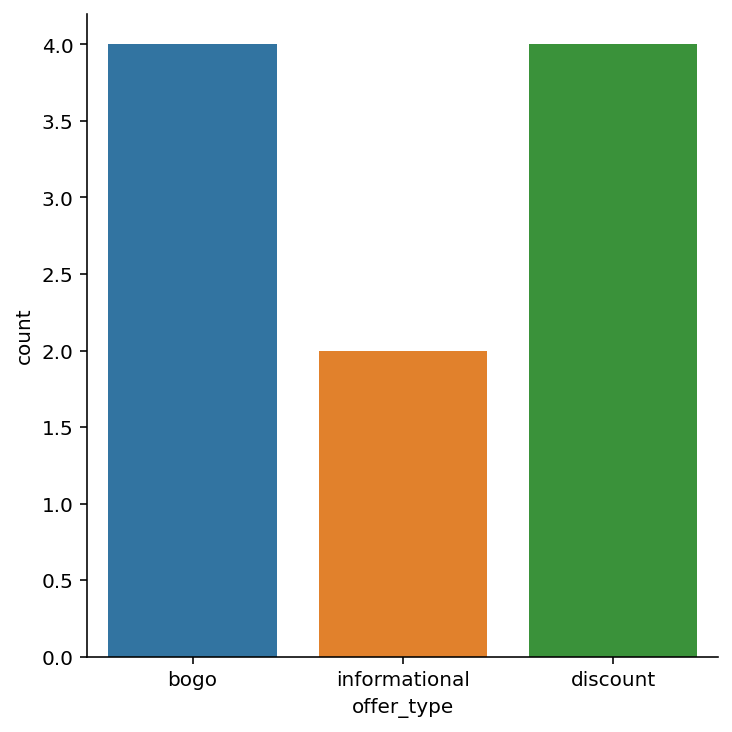

In [75]:
# visualise offer types
sns.catplot(x="offer_type", data=portfolio, kind='count')

In [76]:
print("Received offers can be of type: ", np.unique(df_received_offers.offer_type))
print("Viewed offers can be of type: ", np.unique(df_viewed_offers.offer_type))
print("Completed offers can be of type: ", np.unique(df_completed_offers.offer_type))

Received offers can be of type:  ['bogo' 'discount' 'informational']
Viewed offers can be of type:  ['bogo' 'discount' 'informational']
Completed offers can be of type:  ['bogo' 'discount']


Offer type 'bogo' and 'discount' have events 'offer received', 'offer viewed' and 'offer completed', but offer type 'informational' has only events 'offer received' and 'offer viewed'. 
Therefore, for offer type 'bogo' and 'discount', I will consider the offer completed when there is be an event'offer completed' within the offer duration time.
The offer type 'informational' I will consider completed when viewed.

In [51]:
df_received_offers['viewed'] = 0

In [52]:
# determine if a received offer has been viewed
def check_if_offer_viewed(entry, df_viewed):
    """
    For an offer to be viewed, the client id and offer id 
    simply have to be contained in df_vieweds
    with time no greater than time_received + duration_hrs.
    """
    
    person = entry.person
    offer_id = entry.offer_id
    time_received = entry.time
    offer_duration = entry.duration_hrs
    
    """if ((df_viewed['person'] == 'person') & (df_viewed['offer_id'] == offer_id) &
        (df_viewed['time'] <= time_received + offer_duration)).any():
        return 1
    else:
        return 0
    """
    #print(df_viewed_offers.shape)
    temp = df_viewed.loc[(df_viewed['person'] == person) & (df_viewed['offer_id'] == offer_id) &
        (df_viewed['time'] <= time_received + offer_duration)]
    
    if temp.empty:
        return 0
    else:
        return 1
    
    

def check_if_offer_completed(entry, df_comp):
    """
    For an offer to be completed, the client id and offer id 
    have to be contained in df_comp
    with time no greater than time_received + duration_hrs.
    """
    
    person = entry.person
    offer_id = entry.offer_id
    time_received = entry.time
    offer_duration = entry.duration_hrs
    offer_type = entry.offer_type
    
    if offer_type == 'informational':
        return entry.viewed
    else: #if bogo or discount
        temp = df_comp.loc[(df_comp['person'] == person) & (df_comp['offer_id'] == offer_id) &
        (df_comp['time'] <= time_received + offer_duration)]

        if temp.empty:
            return 0
        else:
            return 1

In [53]:
# test
check_if_offer_viewed(df_received_offers.iloc[2,:], df_viewed_offers)

1

In [54]:
# test: completed offer
check_if_offer_completed(df_received_offers.iloc[0,:], df_completed_offers)

1

In [55]:
temp = df_received_offers.apply(check_if_offer_viewed, axis=1, args=[df_viewed_offers])

In [56]:
print(temp.shape)
print(" Out of received offers, the percentage of viewed ones was: ", sum(temp)/df_received_offers.shape[0]*100)

(76277,)
 Out of received offers, the percentage of viewed ones was:  76.54338791509892


In [57]:
df_received_offers['viewed'] = temp

In [58]:
temp_completed = df_received_offers.apply(check_if_offer_completed, axis=1, args=[df_completed_offers])

In [59]:
df_received_offers['completed'] = temp_completed

In [60]:
# save this to a csv
# df_received_offers.to_csv("offers_data/received_offers_labelled.csv")

In [61]:
print(df_received_offers.shape[0])
print("Viewed offers: ", df_received_offers[df_received_offers.viewed == 1].shape[0])
print("Completed offers: ", df_received_offers[df_received_offers.completed == 1].shape[0])

76277
Viewed offers:  58385
Completed offers:  45135


In [78]:
df_received_offers.head(2)

,person,event,time,offer_id,offer_type,duration,duration_hrs,viewed,completed
78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4b65b9aebfe6a799e6d9-0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,168,1,1
a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc45b7b9fa7c272da2e1d7-0,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,240,1,0


## Add data on offer types from the dataframe 'portfolio' to the processed offers

In [82]:
# ADD INFORMATION FROM PORTOFOLIO TO OFFERS RECEIVED: channels, offer types
df_offers_full = df_received_offers.merge(portfolio[['id', 'difficulty', 'reward', 'channels']], \
                                             how='left', left_on='offer_id', right_on='id')
#df_offers_full.rename({'reward':'reward_offered'}, inplace=True, axis=1)

# one-hot encoding of offer type
df_offers_full = pd.concat([df_offers_full, pd.get_dummies(df_offers_full['offer_type'])], axis=1, ignore_index=False)
df_offers_full.index = df_received_offers.index

# one-hot encoding of chanels
for ch in channels_list:
    df_offers_full[ch] = df_offers_full['channels'].map(lambda x: 1 if ch in x else 0)


In [84]:
df_offers_full.head(3)

,person,event,time,offer_id,offer_type,duration,duration_hrs,viewed,completed,id,difficulty,reward,channels,bogo,discount,informational,email,mobile,social,web
78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4b65b9aebfe6a799e6d9-0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,168,1,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,"[web, email, mobile]",1,0,0,1,1,0,1
a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc45b7b9fa7c272da2e1d7-0,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,240,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,"[web, email]",0,1,0,1,0,0,1
e2127556f4f64592b11af22de27a7932-2906b810c7d4411798c6938adc9daaa5-0,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,discount,7,168,1,0,2906b810c7d4411798c6938adc9daaa5,10,2,"[web, email, mobile]",0,1,0,1,1,0,1


# Data visualisation: offers

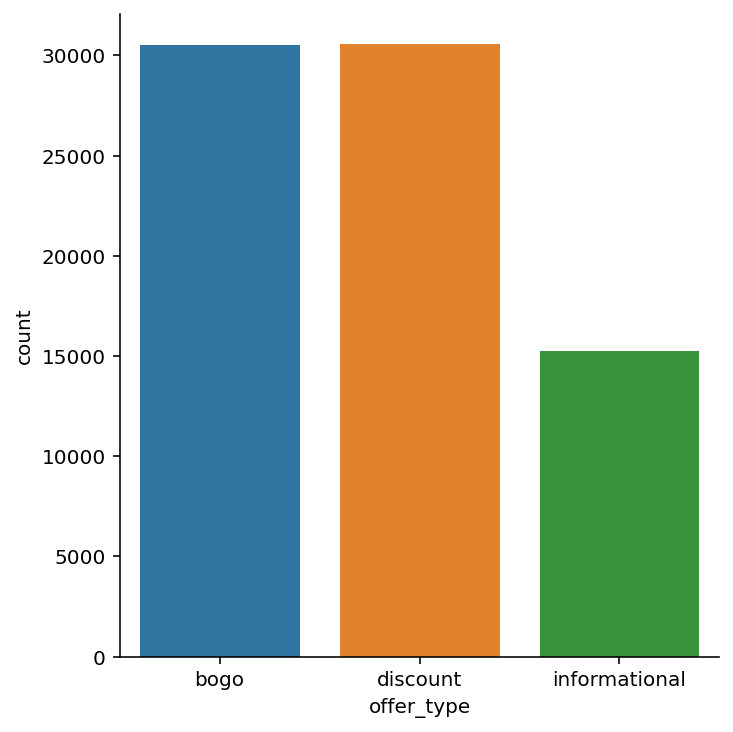

In [88]:
# Look at the distribution of offer types

sns.catplot(x = 'offer_type', data=df_offers_full, kind='count')

<AxesSubplot:xlabel='offer_type', ylabel='completed'>

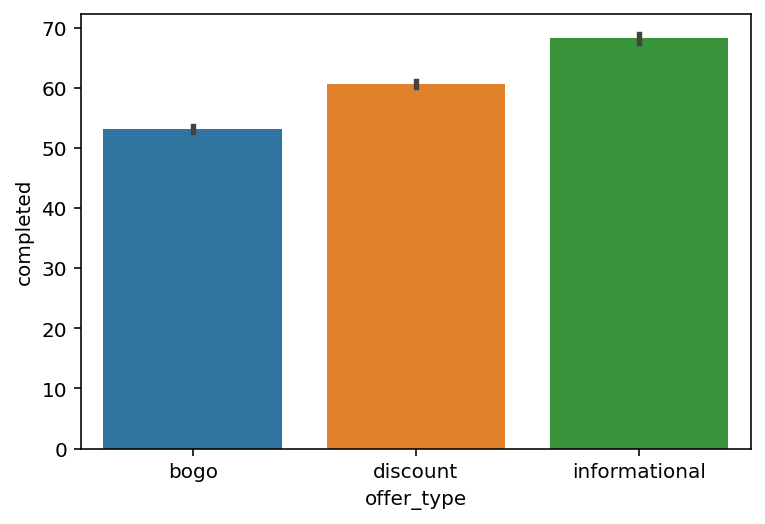

In [89]:
# % of offers of each offer type that is completed

sns.barplot(x = 'offer_type', y='completed', data=df_offers_full, estimator=lambda y: sum(y==1)*100.0/len(y))

In [100]:
# check
off_type = 'bogo'
num_off_type = df_offers_full[df_offers_full.offer_type == off_type].shape[0]
off_type_completed = df_offers_full[(df_offers_full.offer_type == off_type) & (df_offers_full.completed == 1)].shape[0]
off_type_completed/num_off_type

0.5318207154332929

In [101]:
df_offers_full.drop(['event', 'id', 'offer_type', 'channels'], axis=1, inplace=True)

# Market segmentation: Customer profile clustering

In this part, I employ k-means to try to cluster all the customer profiles into several groups depending on their demographic, socio-economic and purchasing characteristics (excluding data on how they react to offers).

## Prepare the features (profile_final) for clustering

In [102]:
# normalize the data into a normalized range, 0-1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

profile_scaled = pd.DataFrame(scaler.fit_transform(profile_final.astype(float)))


profile_scaled.columns = profile_final.columns
profile_scaled.index = profile_final.index

In [103]:
profile_scaled.head()

,gender,age,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency
id,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.0,0.445783,0.911111,0.206253,0.459526,0.75,0.081633,0.083333,0.047871,0.063966,0.055171
78afa995795e4d85b5d9ceeca43f5fef,0.0,0.686747,0.777778,0.243006,0.271348,1.00,0.326531,0.194444,0.099006,0.066146,0.032470
e2127556f4f64592b11af22de27a7932,0.5,0.602410,0.444444,0.049918,0.189997,1.00,0.204082,0.083333,0.035886,0.047952,0.013429
389bc3fa690240e798340f5a15918d5c,0.5,0.566265,0.255556,0.091607,0.132709,1.00,0.367347,0.083333,0.022646,0.030259,0.024561
2eeac8d8feae4a8cad5a6af0499a211d,0.5,0.481928,0.233333,0.140976,0.149820,0.75,0.163265,0.111111,0.009710,0.010379,0.030185


In [104]:
profile_scaled.describe()

,gender,age,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.300438,0.438476,0.393389,0.286604,0.265914,0.648752,0.334669,0.232260,0.072747,0.042154,0.038287
std,0.259057,0.209442,0.239981,0.229953,0.146119,0.291257,0.141338,0.143963,0.080789,0.045634,0.040131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.289157,0.211111,0.114098,0.160422,0.500000,0.224490,0.111111,0.019550,0.010819,0.015605
50%,0.500000,0.445783,0.377778,0.196380,0.245855,0.750000,0.326531,0.194444,0.054106,0.039526,0.028759
75%,0.500000,0.578313,0.555556,0.437191,0.343971,1.000000,0.428571,0.305556,0.100019,0.059506,0.048320
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [105]:
#plt.matshow(profile_scaled.corr())
profile_scaled.corr()

,gender,age,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency
gender,1.000000,-0.144653,-0.220746,0.015424,-0.026465,-0.128334,-0.004970,0.047056,-0.145144,-0.173884,-0.026743
age,-0.144653,1.000000,0.306703,0.012300,-0.633946,0.943455,-0.084491,-0.155885,0.105787,0.186420,0.112412
income,-0.220746,0.306703,1.000000,0.025769,0.438747,0.292369,-0.131375,-0.266050,0.315033,0.465984,0.199476
membership_duration,0.015424,0.012300,0.025769,1.000000,0.007375,0.011217,0.372743,0.425779,0.166242,0.063900,0.524539
income_age,-0.026465,-0.633946,0.438747,0.007375,1.000000,-0.632599,-0.007801,-0.032118,0.124310,0.145830,0.026778
age_group,-0.128334,0.943455,0.292369,0.011217,-0.632599,1.000000,-0.077175,-0.147257,0.106342,0.181701,0.106508
num_trancripts,-0.004970,-0.084491,-0.131375,0.372743,-0.007801,-0.077175,1.000000,0.907123,0.434712,0.090821,-0.239807
num_transactions,0.047056,-0.155885,-0.266050,0.425779,-0.032118,-0.147257,0.907123,1.000000,0.347459,-0.024507,-0.250780
total_transactions,-0.145144,0.105787,0.315033,0.166242,0.124310,0.106342,0.434712,0.347459,1.000000,0.829398,-0.072735
avg_per_transaction,-0.173884,0.186420,0.465984,0.063900,0.145830,0.181701,0.090821,-0.024507,0.829398,1.000000,0.037896


In [106]:
profile_scaled.isnull().sum()

gender                 0
age                    0
income                 0
membership_duration    0
income_age             0
age_group              0
num_trancripts         0
num_transactions       0
total_transactions     0
avg_per_transaction    0
buying_frequency       0
dtype: int64

# Data Modelling

# Market segmentation

In this part, I will use k-mean to segment the customers using the above extracted features that describe their basic purschasing patters (excluding the data on how they react to offers). To choose a "good k", I use the elbow method.
Due to a fairly small feature space, the clustering is performed directly on the created features without using dimensionality reduction (PCA).

In [107]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::137503110434:role/service-role/AmazonSageMaker-ExecutionRole-20210116T223274


In [108]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)

sagemaker-us-east-1-137503110434


In [109]:
# define location to store model artifacts
prefix = 'starbucks'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-137503110434/starbucks/


In [110]:
# define a KMeans estimator
from sagemaker import KMeans

In [111]:
kmeans_train_data_np = profile_scaled.values.astype('float32')

The dataframe with features needs to be transformd into a numpr array and then into a RecordSet, for the KMeans model.

### Train the k-means model

The training of the k-means model is done on a range of K's. That is so that I am able to visualise the elbow graph and select a good k.

In [112]:
K = range(4, 16)  # start from 3/5 and up to 10/12 to see the elbow graph
print("k-Means model is going to be trained on the the range ", list(K))
training_jobs = [] # list of the traning jobs, for extracting model artifacts

k-Means model is going to be trained on the the range  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [113]:
find_good_k = False # set to True if you want to perform the elbow method of searching for good k

In [114]:
if find_good_k:
    for k in K:
        print('starting train job:' + str(k))

        kmeans = KMeans(role=role,
                    instance_count=1,
                    instance_type='ml.c4.xlarge',
                    output_path=output_path,              
                    k=k)

        # convert the transformed dataframe into record_set data
        kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

        #%%time
        # train kmeans
        kmeans.fit(kmeans_formatted_data)
        training_jobs.append(kmeans.latest_training_job.name)

starting train job:4


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:03:09 Starting - Starting the training job...
2021-01-29 19:03:36 Starting - Launching requested ML instancesProfilerReport-1611946989: InProgress
.........
2021-01-29 19:04:57 Starting - Preparing the instances for training.........
2021-01-29 19:06:41 Downloading - Downloading input data
2021-01-29 19:06:41 Training - Downloading the training image...
2021-01-29 19:07:10 Uploading - Uploading generated training model
2021-01-29 19:07:10 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:07:00 INFO 139921179318080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:07:23 Starting - Starting the training job...
2021-01-29 19:07:47 Starting - Launching requested ML instancesProfilerReport-1611947243: InProgress
.........
2021-01-29 19:09:08 Starting - Preparing the instances for training.........
2021-01-29 19:10:54 Downloading - Downloading input data
2021-01-29 19:10:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:10:58 INFO 140261958154048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_dis

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:11:37 Starting - Starting the training job...
2021-01-29 19:11:51 Starting - Launching requested ML instancesProfilerReport-1611947496: InProgress
......
2021-01-29 19:13:05 Starting - Preparing the instances for training............
2021-01-29 19:15:05 Downloading - Downloading input data
2021-01-29 19:15:05 Training - Downloading the training image...
2021-01-29 19:15:39 Uploading - Uploading generated training model
2021-01-29 19:15:39 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:15:29 INFO 139980409333568] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:15:50 Starting - Starting the training job...
2021-01-29 19:15:59 Starting - Launching requested ML instancesProfilerReport-1611947750: InProgress
.........
2021-01-29 19:17:42 Starting - Preparing the instances for training...
2021-01-29 19:18:20 Downloading - Downloading input data...
2021-01-29 19:18:43 Training - Downloading the training image...
2021-01-29 19:19:20 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:19:23 INFO 139621668521792] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:20:05 Starting - Starting the training job...
2021-01-29 19:20:28 Starting - Launching requested ML instancesProfilerReport-1611948005: InProgress
......
2021-01-29 19:21:29 Starting - Preparing the instances for training.........
2021-01-29 19:22:58 Downloading - Downloading input data
2021-01-29 19:22:58 Training - Downloading the training image...
2021-01-29 19:23:31 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:23:21 INFO 139944306448192] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001',

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:24:18 Starting - Starting the training job...
2021-01-29 19:24:45 Starting - Launching requested ML instancesProfilerReport-1611948258: InProgress
......
2021-01-29 19:25:46 Starting - Preparing the instances for training.........
2021-01-29 19:27:10 Downloading - Downloading input data...
2021-01-29 19:27:47 Training - Training image download completed. Training in progress.
2021-01-29 19:27:47 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:27:42 INFO 140450014824256] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'lo

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:28:32 Starting - Starting the training job...
2021-01-29 19:28:57 Starting - Launching requested ML instancesProfilerReport-1611948512: InProgress
.........
2021-01-29 19:30:18 Starting - Preparing the instances for training......
2021-01-29 19:31:31 Downloading - Downloading input data...
2021-01-29 19:32:00 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:32:14 INFO 140502947129152] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'fal

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:32:46 Starting - Starting the training job...
2021-01-29 19:33:10 Starting - Launching requested ML instancesProfilerReport-1611948766: InProgress
......
2021-01-29 19:34:11 Starting - Preparing the instances for training......
2021-01-29 19:35:12 Downloading - Downloading input data
2021-01-29 19:35:12 Training - Downloading the training image......
2021-01-29 19:36:12 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:36:08 INFO 140186472978240] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001',

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:37:00 Starting - Starting the training job...
2021-01-29 19:37:25 Starting - Launching requested ML instancesProfilerReport-1611949019: InProgress
.........
2021-01-29 19:38:46 Starting - Preparing the instances for training.........
2021-01-29 19:40:28 Downloading - Downloading input data...
2021-01-29 19:41:00 Training - Training image download completed. Training in progress.
2021-01-29 19:41:00 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:40:58 INFO 140120702170944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:41:46 Starting - Starting the training job...
2021-01-29 19:42:10 Starting - Launching requested ML instancesProfilerReport-1611949305: InProgress
.........
2021-01-29 19:43:31 Starting - Preparing the instances for training.........
2021-01-29 19:45:14 Downloading - Downloading input data
2021-01-29 19:45:14 Training - Downloading the training image...
2021-01-29 19:45:41 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:45:38 INFO 140678416455488] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.000

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:46:30 Starting - Starting the training job...
2021-01-29 19:46:53 Starting - Launching requested ML instancesProfilerReport-1611949589: InProgress
.........
2021-01-29 19:48:14 Starting - Preparing the instances for training.........
2021-01-29 19:49:55 Downloading - Downloading input data
2021-01-29 19:49:55 Training - Downloading the training image...
2021-01-29 19:50:29 Uploading - Uploading generated training model
2021-01-29 19:50:29 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:50:19 INFO 140420542187328] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 19:50:43 Starting - Starting the training job...
2021-01-29 19:50:52 Starting - Launching requested ML instancesProfilerReport-1611949843: InProgress
.........
2021-01-29 19:52:27 Starting - Preparing the instances for training......
2021-01-29 19:53:27 Downloading - Downloading input data...
2021-01-29 19:54:08 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 19:54:23 INFO 140050172004160] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'fal

In [115]:
from scipy.spatial.distance import cdist

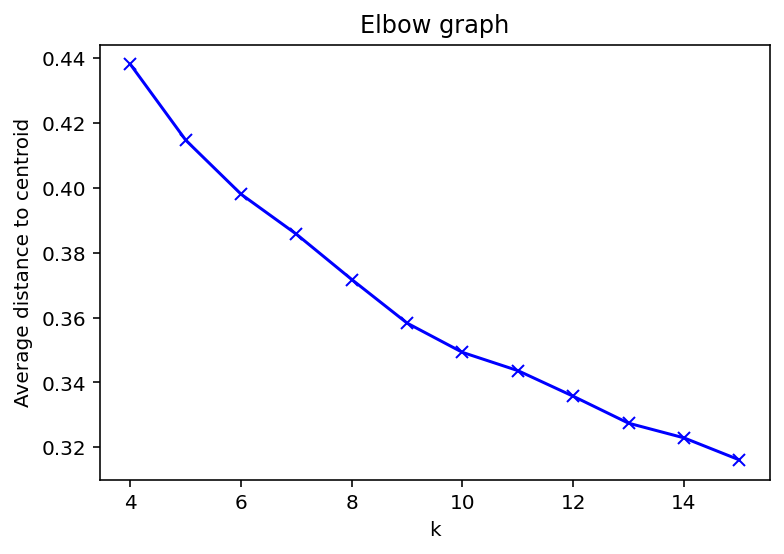

In [116]:
if find_good_k:
    plt.plot()
    colors = ['b', 'g', 'r']
    markers = ['o', 'v', 's']
    models = {}
    distortions = []

    for k in K:
        #s3_client = boto3.client('s3')
        kmeans_job_name = training_jobs[k - K[0]]
        model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

        # download the model file
        boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
        os.system('tar -zxvf model.tar.gz')
        os.system('unzip model_algo-1')


        # get the trained kmeans params using mxnet
        kmeans_model_params = mx.ndarray.load('model_algo-1')

        kmeans_numpy = kmeans_model_params[0].asnumpy()
        distortions.append(sum(np.min(cdist(kmeans_train_data_np, kmeans_numpy, 'euclidean'), axis=1)) / kmeans_train_data_np.shape[0])
        models[k] = kmeans_numpy

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average distance to centroid')
    plt.title('Elbow graph')
    plt.show()

Although the graph above doesn't have a very distinct "elbow", i.e. there is not a very clear k for which the centroid distance stops decreasing at a very sharp rate, I can observe that after k=10 the decrease noticeably slows down. Therefore, I will select a k=10 as a "good value of k". However, I need to have in mind that this kind of elbow graph might be indicative of clusters that are not very distinct, and thus maybe not of a high practical use.

## k-means with the chosen k

In [117]:
NUM_CLUSTERS = 10

In [118]:
kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path=output_path,              
                k=NUM_CLUSTERS)

In [119]:
# convert the transformed dataframe into record_set data
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [120]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-29 21:00:45 Starting - Starting the training job..
2021-01-29 21:03:31 Starting - Preparing the instances for trainingProfilerReport-1611954045: InProgress
...
2021-01-29 21:04:11 Downloading - Downloading input data
2021-01-29 21:04:11 Training - Downloading the training image..
2021-01-29 21:04:40 Uploading - Uploading generated training model
2021-01-29 21:04:40 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/29/2021 21:04:30 INFO 140443962218304] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_ite

# Deploy the trained k-means model

In [121]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!CPU times: user 321 ms, sys: 16.5 ms, total: 338 ms
Wall time: 8min 32s


### Get the predicted cluster for the customer data (kmeans)

In [122]:
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

# Explore the obtained customer clusters

In [123]:
# cluster information for one particular cusotmer
customer_idx = 1
print(cluster_info[customer_idx])

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 6.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.33112597465515137
    }
  }
}



### Visualise the distribution of data over clusters

In [124]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

2.0    1928
1.0    1806
0.0    1740
6.0    1660
5.0    1462
9.0    1375
3.0    1352
8.0    1223
7.0    1179
4.0    1100
Name: 0, dtype: int64


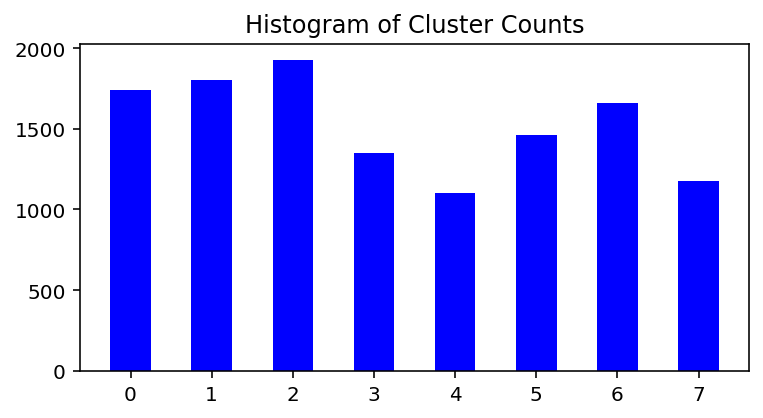

In [125]:
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

# Delete the endpoint

In [126]:
session.delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Explainability of the customer segmentation model

In [127]:
# download and unzip the kmeans model file
kmeans_job_name = kmeans.latest_training_job.name # should be: 'kmeans-2021-01-24-23-58-04-909'
kmeans_job_name

'kmeans-2021-01-29-21-00-45-233'

In [128]:
model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [129]:
kmeans_model_params = mx.ndarray.load('model_algo-1')

# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=profile_final.columns

### Visualise centroids in component space

In [130]:
import seaborn as sns

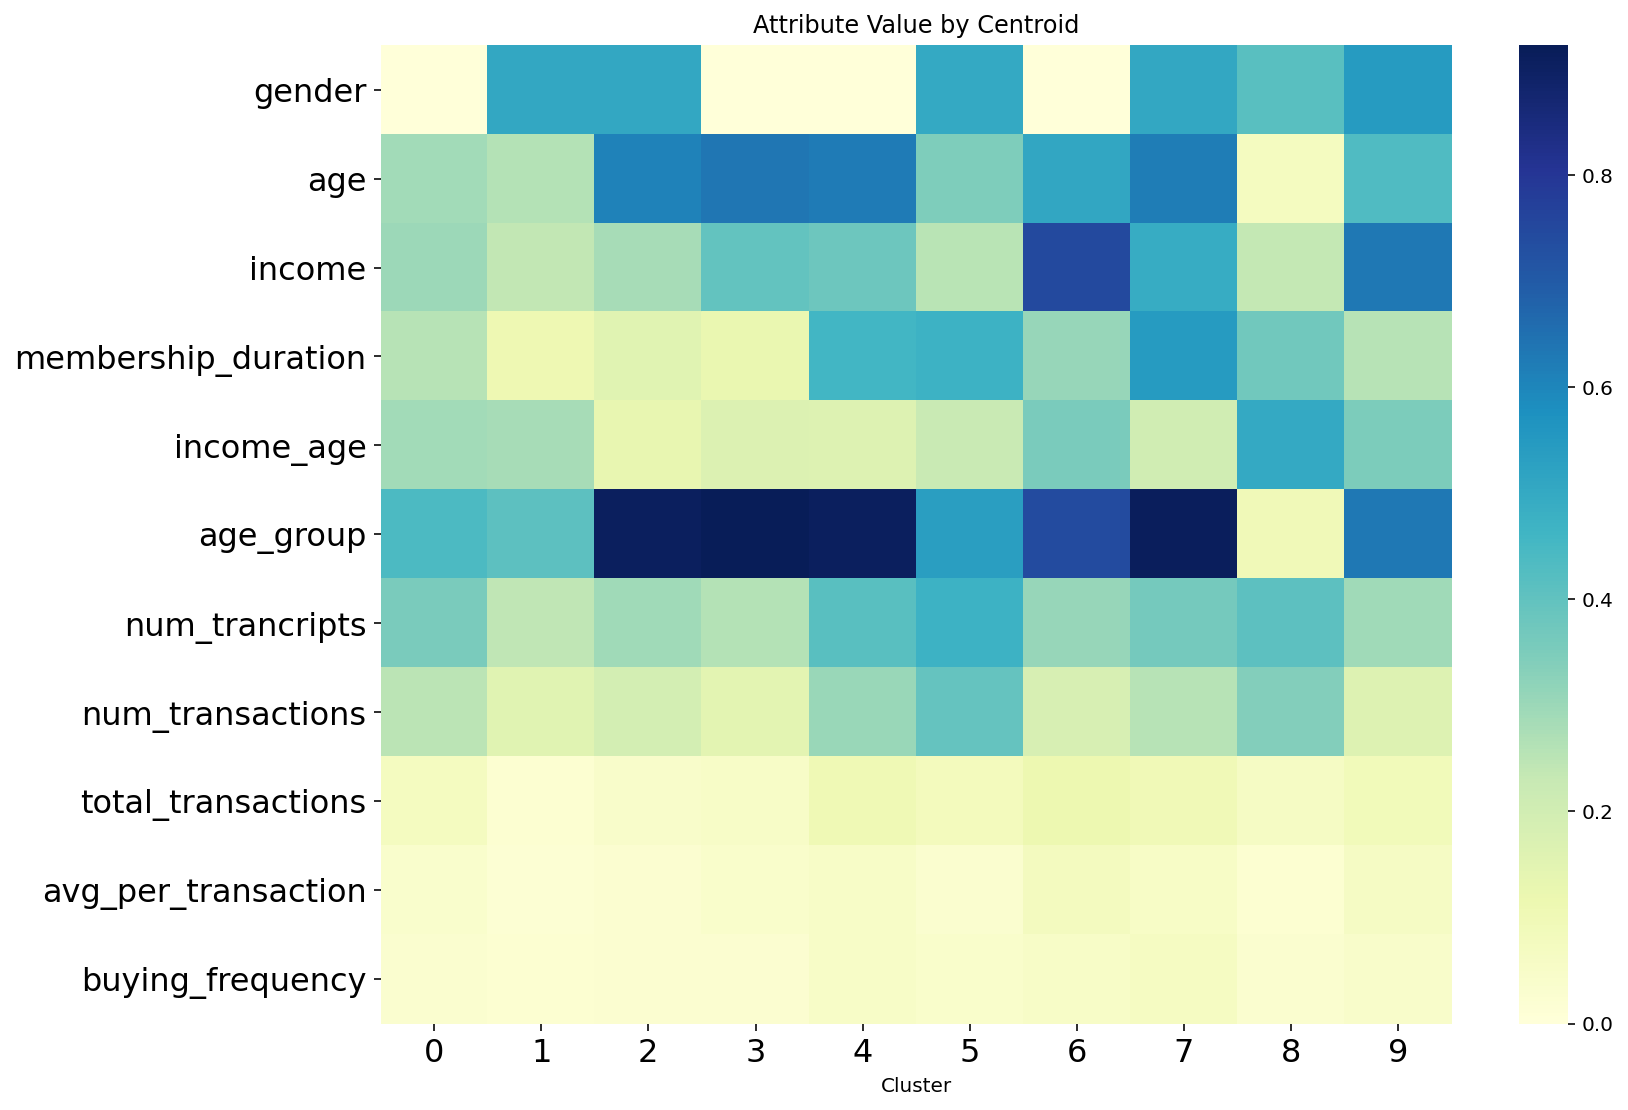

In [131]:
# generate a heatmap in component space
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

### Map cluster back to customer profiles

In [132]:
# add a 'labels' column to the dataframe
profile_final['cluster_label']=list(map(int, cluster_labels))

# sort by cluster label
sorted_profiles = profile_final.sort_values('cluster_label', ascending=True)
# view first 10 customers of cluster 0
sorted_profiles.head(10)

,gender,age,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency,cluster_label
id,,,,,,,,,,,,
7a984e5d61aa4a68a0466fc52dc7dfd5,0,50,72000.0,870,1440.000000,3,11,5.0,90.67,15.111667,145.000000,0
42b08cfe20c54e15ab6815c4a1d9d2cf,0,31,33000.0,352,1064.516129,2,15,7.0,104.58,13.072500,44.000000,0
35dd2c597c7e43d8b8c53ade81e8350f,0,22,31000.0,148,1409.090909,1,13,6.0,22.39,3.198571,21.142857,0
37bd8088aaa14e7c8e3c6cbff6b744c3,0,49,55000.0,926,1122.448980,3,21,10.0,143.79,13.071818,84.181818,0
89507aca336640968fbee05111d881da,0,29,54000.0,329,1862.068966,2,14,7.0,21.05,2.631250,41.125000,0
d1dacf8fe14742f281ce02c4a30c01ab,0,47,69000.0,783,1468.085106,3,20,7.0,153.87,19.233750,97.875000,0
01772eae932447f9a853461a60820dc6,0,54,30000.0,379,555.555556,3,16,8.0,58.28,6.475556,42.111111,0
5be5efe41a974a2aafce169cbb6f1cc9,0,51,81000.0,577,1588.235294,3,20,6.0,88.50,12.642857,82.428571,0
b834c0ff6f2f4a08a39b2122a6a45f7e,0,40,31000.0,184,775.000000,3,35,21.0,386.37,17.562273,8.363636,0


In [133]:
selected_customer_cluster = 2 # select some cluster

# get all customer with label == selected_customer_cluster
cluster_selected = profile_final[profile_final['cluster_label'] == selected_customer_cluster]
cluster_selected.head()

,gender,age,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency,cluster_label
id,,,,,,,,,,,,
e2127556f4f64592b11af22de27a7932,1,68,70000.0,92,1029.411765,5,12,3.0,57.73,14.432500,23.000000,2
389bc3fa690240e798340f5a15918d5c,1,65,53000.0,168,815.384615,5,20,3.0,36.43,9.107500,42.000000,2
2eeac8d8feae4a8cad5a6af0499a211d,1,58,51000.0,258,879.310345,4,10,4.0,15.62,3.124000,51.600000,2
6445de3b47274c759400cd68131d91b4,1,57,42000.0,208,736.842105,4,14,6.0,19.10,2.728571,29.714286,2
ca82e1ebc759402c8ab95c341755bdf1,1,63,56000.0,14,888.888889,4,18,9.0,121.62,12.162000,1.400000,2


## Merge profile information and offers data: complete dataset for ML training

In [134]:
df_offers_full.shape

(76277, 16)

In [135]:
#df_offers_full[df_offers_full.person == 'e12aeaf2d47d42479ea1c4ac3d8286c6']
#df_offers_full[df_offers_full.viewed == 1]

In [136]:
# add profile information
df_offers_final = df_offers_full.merge(profile_final, how='left', left_on='person', right_index=True)

In [137]:
df_offers_final.head()

,person,time,offer_id,duration,duration_hrs,viewed,completed,difficulty,reward,bogo,...,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency,cluster_label
78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4b65b9aebfe6a799e6d9-0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,168,1,1,5,5,1,...,100000.0,444.0,1333.333333,5.0,18.0,7.0,159.27,19.90875,55.5,6.0
a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc45b7b9fa7c272da2e1d7-0,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,240,1,0,20,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e2127556f4f64592b11af22de27a7932-2906b810c7d4411798c6938adc9daaa5-0,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,7,168,1,0,10,2,0,...,70000.0,92.0,1029.411765,5.0,12.0,3.0,57.73,14.43250,23.0,2.0
8ec6ce2a7e7949b1bf142def7d0e0586-fafdcd668e3743c1bb461111dcafc2a4-0,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,10,240,1,0,10,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68617ca6246f4fbc85e91a2a49552598-4d5c57ea9a6940dd891ad53e9dbe8da0-0,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,5,120,1,0,10,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
df_offers_final.columns.values

array(['person', 'time', 'offer_id', 'duration', 'duration_hrs', 'viewed',
       'completed', 'difficulty', 'reward', 'bogo', 'discount',
       'informational', 'email', 'mobile', 'social', 'web', 'gender',
       'age', 'income', 'membership_duration', 'income_age', 'age_group',
       'num_trancripts', 'num_transactions', 'total_transactions',
       'avg_per_transaction', 'buying_frequency', 'cluster_label'],
      dtype=object)

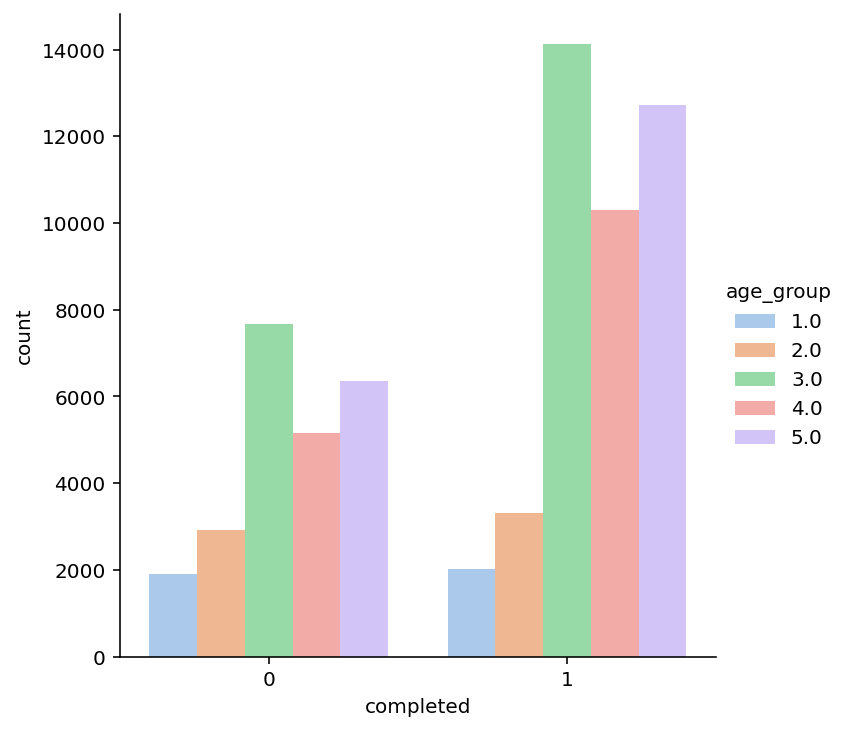

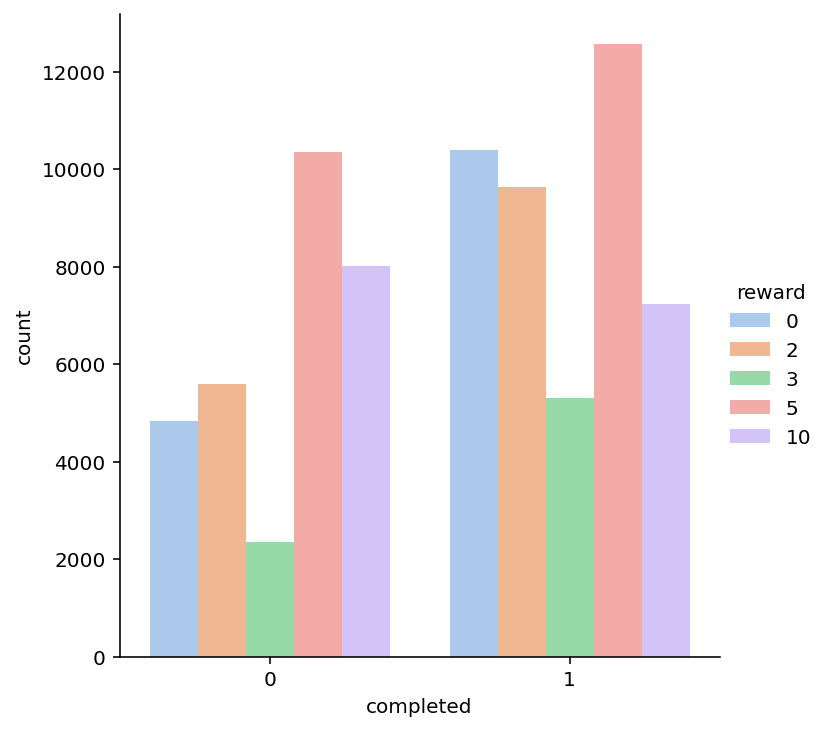

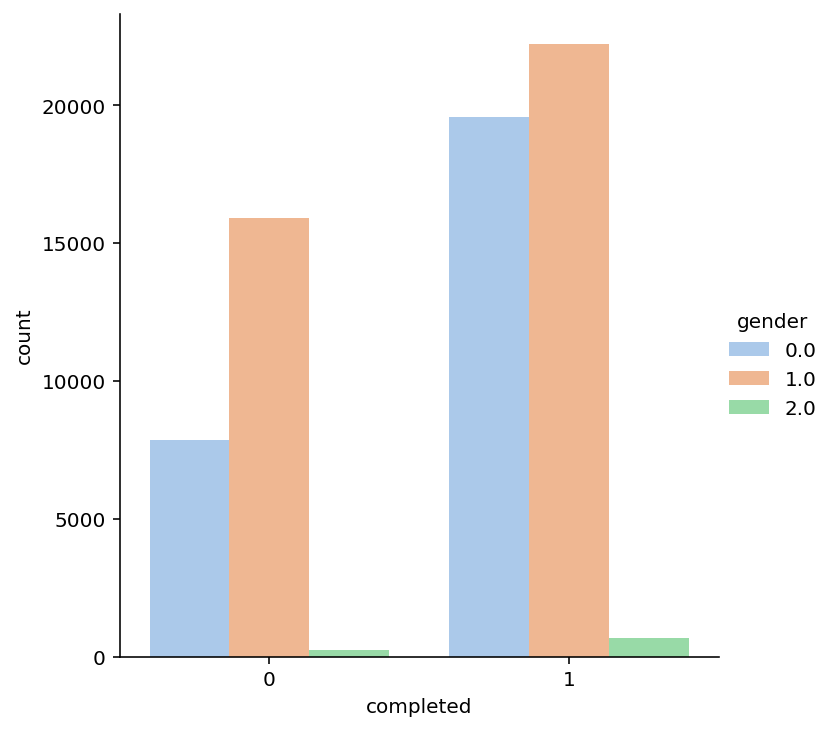

In [156]:
# How customers respond to offer by certain groups

group_customers_by = ['age_group', 'reward', 'gender']

for g in group_customers_by:
    sns.catplot(x='completed', hue=g, data=df_offers_final, kind='count', palette='pastel')

In [175]:
np.unique(df_offers_final.email == 1)

array([ True])

### Q: Which features I should drop so to avoid data leakage?

Features for dropping:
* person
* offer_id
* duration_hrs
* viewed

* completed - USED AS THE LABEL (GROUND TRUTH)

In [168]:
df_offers_final.drop(['person', 'offer_id', 'viewed', 'duration_hrs'], axis=1, inplace=True)

In [169]:
df_offers_final.shape

(76277, 24)

## Feature correlation analysis

In [176]:
# Create correlation matrix
corr_matrix = df_offers_final.corr().abs().round(2)

display(corr_matrix)

,time,duration,completed,difficulty,reward,bogo,discount,informational,email,mobile,...,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency,cluster_label
time,1.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,NaN,0.00,...,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00
duration,0.00,1.00,0.05,0.81,0.16,0.18,0.74,0.68,NaN,0.53,...,0.00,0.00,0.00,0.00,0.04,0.03,0.02,0.00,0.01,0.00
completed,0.06,0.05,1.00,0.12,0.15,0.10,0.02,0.09,NaN,0.08,...,0.19,0.17,0.05,0.08,0.37,0.25,0.36,0.28,0.03,0.14
difficulty,0.00,0.81,0.12,1.00,0.47,0.03,0.60,0.70,NaN,0.74,...,0.00,0.00,0.00,0.00,0.02,0.01,0.01,0.00,0.00,0.00
reward,0.00,0.16,0.15,0.47,1.00,0.79,0.29,0.62,NaN,0.08,...,0.00,0.00,0.00,0.00,0.04,0.03,0.01,0.00,0.01,0.01
bogo,0.00,0.18,0.10,0.03,0.79,1.00,0.67,0.41,NaN,0.27,...,0.00,0.00,0.00,0.00,0.03,0.02,0.01,0.00,0.01,0.01
discount,0.00,0.74,0.02,0.60,0.29,0.67,1.00,0.41,NaN,0.41,...,0.00,0.00,0.00,0.00,0.02,0.02,0.01,0.00,0.01,0.00
informational,0.00,0.68,0.09,0.70,0.62,0.41,0.41,1.00,NaN,0.17,...,0.00,0.00,0.00,0.00,0.07,0.04,0.02,0.00,0.02,0.01
email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobile,0.00,0.53,0.08,0.74,0.08,0.27,0.41,0.17,NaN,1.00,...,0.00,0.00,0.00,0.00,0.04,0.03,0.01,0.00,0.02,0.00


<AxesSubplot:>

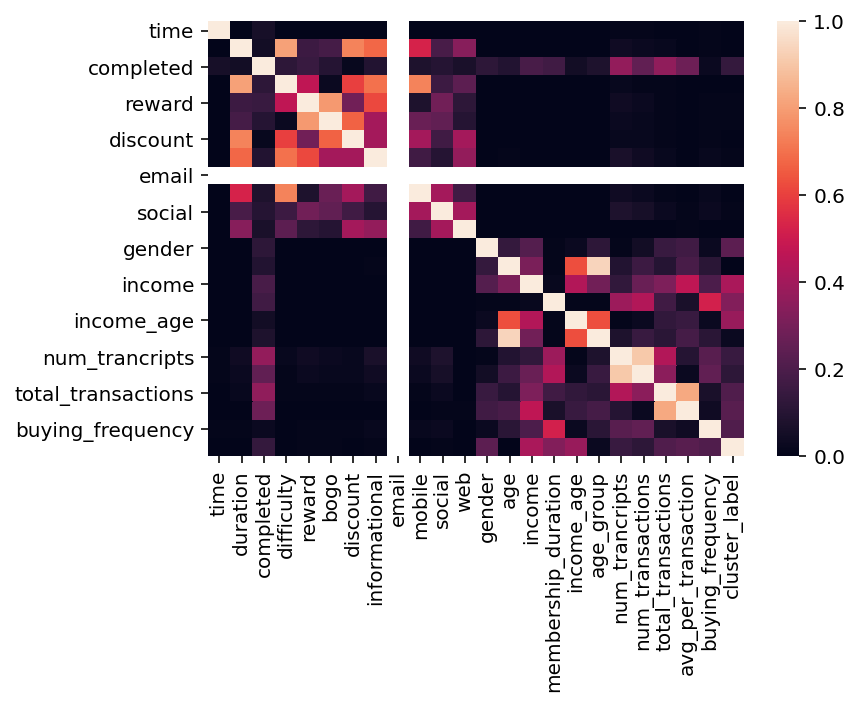

In [177]:
# visualise corr matrix
sns.heatmap(corr_matrix) #df_new.corr())

### Observations on feature correlation:
* The feature 'email' is always 1 - it can be dropped
* All the other feature correlated with the target ('completed') fairly weakly, coefficients ranging from 0.02 to 0.37. Therefore, I will keep all of them to be used in training the binary classifier. 
* Platform on which the offer was delivered to the customer doesn't seem to have a lot of influence on the offer completion.
* As expected, historical transactions of a customers are a more relevant factor for estimating the chances of someone completing an offer.
* Out of all the offer parameters, there is some indication of reward being the most significant one.

In [178]:
df_offers_final.drop(['email'], axis=1, inplace=True)

In [179]:
# data observation without the labels
X = df_offers_final.drop('completed', axis=1).values
print(X.shape)

# labels
y = df_offers_final['completed'].values
print(y.shape)

(76277, 22)
(76277,)


In [181]:
df_offers_final.head()

,time,duration,completed,difficulty,reward,bogo,discount,informational,mobile,social,...,income,membership_duration,income_age,age_group,num_trancripts,num_transactions,total_transactions,avg_per_transaction,buying_frequency,cluster_label
78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4b65b9aebfe6a799e6d9-0,0,7,1,5,5,1,0,0,1,0,...,100000.0,444.0,1333.333333,5.0,18.0,7.0,159.27,19.90875,55.5,6.0
a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc45b7b9fa7c272da2e1d7-0,0,10,0,20,5,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e2127556f4f64592b11af22de27a7932-2906b810c7d4411798c6938adc9daaa5-0,0,7,0,10,2,0,1,0,1,0,...,70000.0,92.0,1029.411765,5.0,12.0,3.0,57.73,14.43250,23.0,2.0
8ec6ce2a7e7949b1bf142def7d0e0586-fafdcd668e3743c1bb461111dcafc2a4-0,0,10,0,10,2,0,1,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68617ca6246f4fbc85e91a2a49552598-4d5c57ea9a6940dd891ad53e9dbe8da0-0,0,5,0,10,10,1,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
# How many examples from each class do I have?
pos_examples = df_offers_final[df_offers_final.completed == 1].shape[0]
neg_examples = df_offers_final[df_offers_final.completed == 0].shape[0]
total_examples = df_offers_final.shape[0]
assert pos_examples + neg_examples == total_examples
print("There are ", round(pos_examples/total_examples * 100, 2), "% of positive examples, and ", \
     round(neg_examples/total_examples * 100, 2), "% of negative examples.")

There are  59.17 % of positive examples, and  40.83 % of negative examples.


## Split data for classification into training and test set

Since around 59% of training examples are positive, that is, offers that have been completed, I can conclude that I have at hands a pretty well balanced data set. Nevertheless, when splitting the data for training and testing, I will honor the class representation and perform stratified sampling to make sure that the shares of each class in each of the subsets (train, test, val) reflect their shares in the full dataset.

In [183]:
from sklearn.model_selection import train_test_split

In [184]:
random_seed = 1

# split 60-20-20: train-val-test
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=random_seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=random_seed, stratify=y_test_val)

In [185]:
# check the stratified samplings
print("Percentage of positive examples in the train set: ", sum(y_train==1) / len(y_train) * 100)
print("Percentage of positive examples in the validation set: ", sum(y_val==1) / len(y_val) * 100)
print("Percentage of positive examples in the test set: ", sum(y_test==1) / len(y_test) * 100)

Percentage of positive examples in the train set:  59.17274832845344
Percentage of positive examples in the validation set:  59.1740412979351
Percentage of positive examples in the test set:  59.17016255899318


# Standardise the train and test data

In [186]:
# normalize the data into a normalized range, 0-1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# Create CSV files: train and test

In [187]:
def make_csv(X, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    
    df_temp = pd.concat([pd.DataFrame(y), pd.DataFrame(X)], axis=1).dropna(axis=0, how='any')
    print("Shape of DF ", filename, " is: ", df_temp.shape)
    df_temp.to_csv(os.path.join(data_dir, filename), header=False, index=False)
    
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [188]:
# the name of directory where to save the features data
data_dir = 'offers_data'

make_csv(X_train_scaled, y_train, filename='train.csv', data_dir=data_dir)
make_csv(X_val_scaled, y_val, filename='validation.csv', data_dir=data_dir)
make_csv(X_test_scaled, y_test, filename='test.csv', data_dir=data_dir)

Shape of DF  train.csv  is:  (39899, 23)
Path created: offers_data/train.csv
Shape of DF  validation.csv  is:  (13291, 23)
Path created: offers_data/validation.csv
Shape of DF  test.csv  is:  (13311, 23)
Path created: offers_data/test.csv
